In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.interpolate import make_interp_spline

set_matplotlib_formats("svg")

In [2]:
import numpy as np
import pandas as pd
import os
import json

In [3]:
def eng_by_coeff(df, coeff):
    res = None
    for entry, val in coeff.items():
        if res is None:
            res = val * df.loc[entry]
        else:
            res += val * df.loc[entry]
    return res * 627.51

In [4]:
para_b3lyp = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.2,
    "eng_purexc_LDA_X": 0.08,
    "eng_purexc_GGA_X_B88": 0.72,
    "eng_purexc_LDA_C_VWN_RPA": 0.19,
    "eng_purexc_GGA_C_LYP": 0.81
}
para_b3lyp5 = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.2,
    "eng_purexc_LDA_X": 0.08,
    "eng_purexc_GGA_X_B88": 0.72,
    "eng_purexc_LDA_C_VWN": 0.19,
    "eng_purexc_GGA_C_LYP": 0.81
}
para_xyg3 = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.8033,
    "eng_purexc_LDA_X": -0.0140,
    "eng_purexc_GGA_X_B88": 0.2107,
    "eng_purexc_GGA_C_LYP": 0.6789,
    "eng_corr_MP2": 0.3211
}
para_xyg7 = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.8971,
    "eng_purexc_LDA_X": 0.2055,
    "eng_purexc_GGA_X_B88": -0.1408,
    "eng_purexc_LDA_C_VWN_RPA": 0.4056,
    "eng_purexc_GGA_C_LYP": 0.1159,
    "eng_corr_MP2_OS": 0.4052,
    "eng_corr_MP2_SS": 0.2589,
}
para_cr = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.851546,
    "eng_purexc_LDA_X": 0.209516,
    "eng_purexc_GGA_X_B88": -0.061062,
    "eng_purexc_LDA_C_VWN_RPA": 0.168713,
    "eng_purexc_GGA_C_LYP": 0.204008,
    "eng_corr_MP2_OS": 0.460703 * (1 - 0.596938),
    "eng_corr_MP2_SS": 0.214325 * (1 - 0.596938),
    "eng_corr_MP2CR_OS": 0.460703 * 0.596938,
    "eng_corr_MP2CR_SS": 0.214325 * 0.596938,
}
para_siepa = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.872368,
    "eng_purexc_LDA_X": 0.297015,
    "eng_purexc_GGA_X_B88": -0.169383,
    "eng_purexc_LDA_C_VWN_RPA": 0.334350,
    "eng_purexc_GGA_C_LYP": 0.088983,
    "eng_corr_MP2_OS": 0.479659 * (1 - 1.421052),
    "eng_corr_MP2_SS":-0.004645 * (1 - 1.421052),
    "eng_corr_SIEPA_OS": 0.479659 * 1.421052,
    "eng_corr_SIEPA_SS":-0.004645 * 1.421052,
}
para_iepa = {
    "eng_noxc": 1,
    "eng_exx_HF": 0.716712,
    "eng_purexc_LDA_X": 0.272940,
    "eng_purexc_GGA_X_B88": 0.010348,
    "eng_purexc_LDA_C_VWN_RPA": 0.359041,
    "eng_purexc_GGA_C_LYP": 0.247560,
    "eng_corr_MP2_OS": 0.286591 * (1 - 1.108974),
    "eng_corr_MP2_SS": 0.102393 * (1 - 1.108974),
    "eng_corr_IEPA_OS": 0.286591 * 1.108974,
    "eng_corr_IEPA_SS": 0.102393 * 1.108974,
}
para_cr3 = {
    "eng_noxc": 1,
    "eng_exx_HF": 1,
    "eng_corr_MP2": 0.5,
    "eng_corr_MP2CR": 0.5,
}
para_hf = {
    "eng_noxc": 1,
    "eng_exx_HF": 1,
}
para_mp2 = {
    "eng_noxc": 1,
    "eng_exx_HF": 1,
    "eng_corr_MP2": 1,
}

In [5]:
bond_list = np.concatenate([
    np.arange(0.5, 2.0, 0.1),
    np.arange(2.0, 3.0, 0.2),
    np.arange(3.0, 4.5, 0.5),
])
bond_list = [np.round(i, 1) for i in bond_list]

In [6]:
with open("ref-N2.json", "r") as f:
    ref = json.load(f)

In [7]:
res_b3lyp = pd.read_csv("res-b3lyp.csv", header=[0], index_col=[0])
res_hf = pd.read_csv("res-hf.csv", header=[0], index_col=[0])
res_post = pd.read_csv("res-post.csv", header=[0], index_col=[0])

In [8]:
def get_res_syst(res):
    res_syst = res[[item for item in res if item.split("_")[0] == "N2"]]
    res_syst = res_syst.sub(2 * res["N"], axis=0)
    res_syst.columns = [float(item.split("_")[1]) for item in res_syst.columns]
    return res_syst

In [9]:
res_b3lyp = get_res_syst(res_b3lyp)
res_hf = get_res_syst(res_hf)
res_post = get_res_syst(res_post)

In [10]:
def get_spl(ser, x=None):
    if x is not None:
        ser = ser[x]
    ser = ser[~ser.isna()]
    x = np.asarray(ser.index, dtype=float)
    val = np.asarray(ser, dtype=float)
    return make_interp_spline(x, val)

In [11]:
ser = 627.51 * res_post.loc["CCSD"]

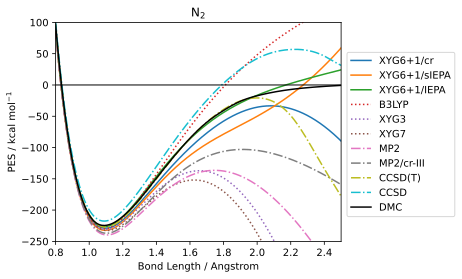

In [12]:
x = bond_list
spl_dict = {
    "XYG6+1/cr"   : get_spl(eng_by_coeff(res_b3lyp, para_cr   )),
    "XYG6+1/sIEPA": get_spl(eng_by_coeff(res_b3lyp, para_siepa)),
    "XYG6+1/IEPA" : get_spl(eng_by_coeff(res_b3lyp, para_iepa )),
    "XYG3"        : get_spl(eng_by_coeff(res_b3lyp, para_xyg3 )),
    "XYG7"        : get_spl(eng_by_coeff(res_b3lyp, para_xyg7 )),
    "B3LYP"       : get_spl(eng_by_coeff(res_b3lyp, para_b3lyp)),
    "HF"          : get_spl(627.51 * res_post.loc["HF"]        ),
    "MP2"         : get_spl(627.51 * res_post.loc["MP2"]       ),
    "CCSD"        : get_spl(627.51 * res_post.loc["CCSD"]      ),
    "CCSD(T)"     : get_spl(627.51 * res_post.loc["CCSD(T)"]   ),
    "MP2/cr-III"  : get_spl(eng_by_coeff(res_hf   , para_cr3  )),
    "DMC"         : make_interp_spline(
        [x for x in bond_list if x not in [2.2, 2.8]],
        [ref[str(x)] * 627.51 for x in bond_list if x not in [2.2, 2.8]], k=3),
}

fig, ax = plt.subplots(figsize=(5, 4))

x = np.linspace(0.8, 3, 1000)

# ax.plot(x, np.zeros_like(x), color="black", linewidth=1)

for method in ["XYG6+1/cr", "XYG6+1/sIEPA", "XYG6+1/IEPA"]:
    ax.plot(x, spl_dict[method](x), label=method)
for method in ["B3LYP", "XYG3", "XYG7"]:
    ax.plot(x, spl_dict[method](x), label=method, linestyle=":")
for method in ["MP2", "MP2/cr-III", "CCSD(T)", "CCSD"]:
    ax.plot(x, spl_dict[method](x), label=method, linestyle="-.")
    
ax.plot(x, spl_dict["DMC"](x), label="DMC", color="black")
ax.plot(x, np.zeros_like(x), linewidth=1, color="black")

ax.set_xlabel("Bond Length / Angstrom")
ax.set_ylabel("PES / kcal mol${}^{-1}$")
ax.set_title("N$_2$")

ax.set_xlim(0.8, 2.5)
ax.set_ylim(-250, 100)

legend = fig.legend(bbox_to_anchor=(1.1, 0.52, 0.2, 0.3))

fig.tight_layout()
outside_artists = [legend]
fig.savefig("../curve-N2.pdf", bbox_extra_artists=outside_artists, bbox_inches="tight")